In [1]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import plotly.express as px

In [2]:
#load the dataset
file_path = 'hospital_readmissions.csv'
data = pd.read_csv(file_path)

In [3]:
# Display the first 5 rows of the data
print(data.head())

   Patient_ID  Age  Gender Admission_Type      Diagnosis  Num_Lab_Procedures  \
0           1   69   Other      Emergency  Heart Disease                  33   
1           2   32  Female         Urgent       Diabetes                  81   
2           3   78  Female         Urgent  Heart Disease                  75   
3           4   38    Male       Elective       Diabetes                  77   
4           5   41  Female         Urgent       Diabetes                  50   

   Num_Medications  Num_Outpatient_Visits  Num_Inpatient_Visits  \
0                2                      4                     1   
1               10                      4                     4   
2               29                      4                     0   
3               11                      2                     3   
4               25                      3                     4   

   Num_Emergency_Visits  Num_Diagnoses A1C_Result Readmitted  
0                     1              5        NaN    

In [4]:
# Info about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Patient_ID             1000 non-null   int64 
 1   Age                    1000 non-null   int64 
 2   Gender                 1000 non-null   object
 3   Admission_Type         1000 non-null   object
 4   Diagnosis              1000 non-null   object
 5   Num_Lab_Procedures     1000 non-null   int64 
 6   Num_Medications        1000 non-null   int64 
 7   Num_Outpatient_Visits  1000 non-null   int64 
 8   Num_Inpatient_Visits   1000 non-null   int64 
 9   Num_Emergency_Visits   1000 non-null   int64 
 10  Num_Diagnoses          1000 non-null   int64 
 11  A1C_Result             566 non-null    object
 12  Readmitted             1000 non-null   object
dtypes: int64(8), object(5)
memory usage: 101.7+ KB
None


In [5]:
# Basic stastistic info of the dataset
print(data.describe())

        Patient_ID          Age  Num_Lab_Procedures  Num_Medications  \
count  1000.000000  1000.000000         1000.000000      1000.000000   
mean    500.500000    51.665000           50.836000        15.661000   
std     288.819436    21.989459           28.075137         8.230177   
min       1.000000    18.000000            1.000000         1.000000   
25%     250.750000    34.000000           27.000000         9.000000   
50%     500.500000    50.500000           52.000000        16.000000   
75%     750.250000    69.000000           75.000000        23.000000   
max    1000.000000   150.000000           99.000000        35.000000   

       Num_Outpatient_Visits  Num_Inpatient_Visits  Num_Emergency_Visits  \
count            1000.000000           1000.000000           1000.000000   
mean                2.016000              2.019000              1.956000   
std                 1.399894              1.416561              1.409983   
min                 0.000000              0.000

In [6]:
# Check for missing values
print(data.isnull().sum())

Patient_ID                 0
Age                        0
Gender                     0
Admission_Type             0
Diagnosis                  0
Num_Lab_Procedures         0
Num_Medications            0
Num_Outpatient_Visits      0
Num_Inpatient_Visits       0
Num_Emergency_Visits       0
Num_Diagnoses              0
A1C_Result               434
Readmitted                 0
dtype: int64


In [7]:
# Upon inspecting the data we have found a few things.
# 1) There is 434 null values in 'A1C_Result' column, which is close to 43% of the data
# 2) The max value is Age is showing 150 which should not be possible
# 3) The max value in Num_Lab_procedures is 99 which is also strange.

In [8]:
# After a google search we found A1C test is done to check diabetic level of patients which is important info
# As we cannot drop the table we need to fill the null values with other methods
# Since it's medical data, we shouldn't add more values and create bias but we can label it as Unknown. 

In [9]:
# Replace missing values in 'A1C_result' with 'Unknown'
data['A1C_Result'].fillna('Unknown', inplace=True)

In [10]:
# Verify the data has been changed
print(data['A1C_Result'].value_counts())

A1C_Result
Unknown     434
Abnormal    301
Normal      265
Name: count, dtype: int64


In [11]:
# Solving the outlier in 'Age' column
outliers_age = data[data['Age']==150].shape[0]
print(outliers_age)

10


In [12]:
# Upon checking manually it's found that there is 10 consecutive rows with 150 as age and the rest is under 84
# We can remove the 10 rows with this outlier.
data = data[data['Age'] != 150]
print(data['Age'].max())

84


In [13]:
# Next we can do One Hot Encoding to convert categorical variables to numberical format so that machine can process data better.
categorical_cols = ['Gender', 'Admission_Type', 'Diagnosis', 'A1C_Result']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
# Convert 'Readmitted' to a binary numerical variable
data_encoded['Readmitted'] = data_encoded['Readmitted'].map({'Yes': 1, 'No': 0})
print(data_encoded.head())

   Patient_ID  Age  Num_Lab_Procedures  Num_Medications  \
0           1   69                  33                2   
1           2   32                  81               10   
2           3   78                  75               29   
3           4   38                  77               11   
4           5   41                  50               25   

   Num_Outpatient_Visits  Num_Inpatient_Visits  Num_Emergency_Visits  \
0                      4                     1                     1   
1                      4                     4                     1   
2                      4                     0                     3   
3                      2                     3                     4   
4                      3                     4                     1   

   Num_Diagnoses  Readmitted  Gender_Male  Gender_Other  \
0              5           1        False          True   
1              6           0        False         False   
2              5           0       

In [14]:
# To find the important features, we will be running feature selection with Random Forest
# Create a train test split and run the model
target = 'Readmitted'
x = data_encoded.drop(target, axis=1) # Features
y = data_encoded[target] # Target Variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

                     Feature  Importance
0                 Patient_ID    0.148375
2         Num_Lab_Procedures    0.139301
1                        Age    0.137105
3            Num_Medications    0.121213
7              Num_Diagnoses    0.086169
4      Num_Outpatient_Visits    0.065151
5       Num_Inpatient_Visits    0.063074
6       Num_Emergency_Visits    0.061006
16        A1C_Result_Unknown    0.022408
8                Gender_Male    0.022244
11     Admission_Type_Urgent    0.020657
15         A1C_Result_Normal    0.020252
10  Admission_Type_Emergency    0.019801
12   Diagnosis_Heart Disease    0.019055
13       Diagnosis_Infection    0.018672
14          Diagnosis_Injury    0.018105
9               Gender_Other    0.017412


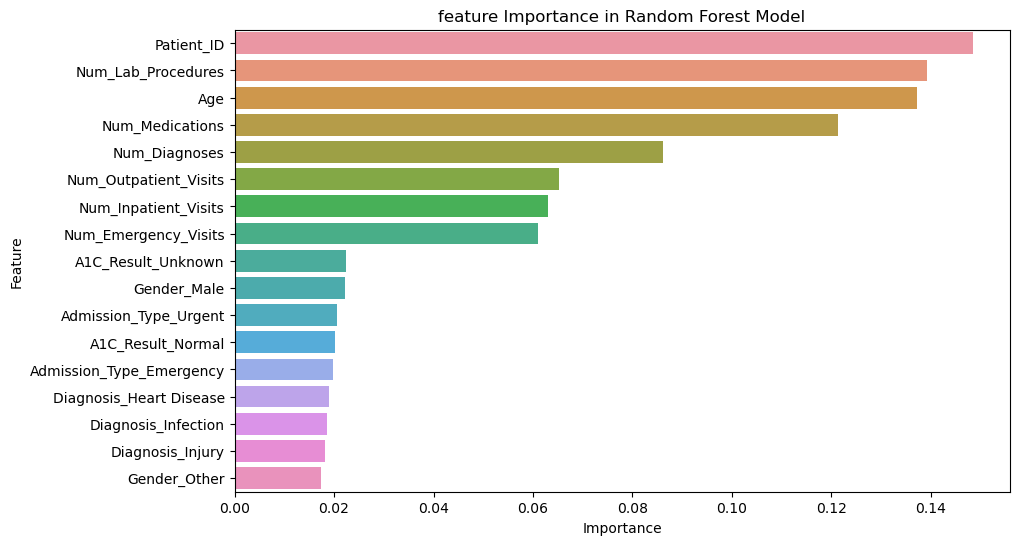

In [15]:
# Extracting and visualizing feature importances
importances = rf.feature_importances_

features = pd.DataFrame({
    'Feature' : x_train.columns,
    'Importance' : importances
})

features_sorted = features.sort_values(by='Importance', ascending=False)

print(features_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_sorted)
plt.title('feature Importance in Random Forest Model')
plt.show()

In [16]:
# Patient_ID just acts as an id in heath data. It can skew the results.
# Remove patient_ID
x_train = x_train.drop('Patient_ID', axis=1)
x_test = x_test.drop('Patient_ID', axis=1)

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

                     Feature  Importance
1         Num_Lab_Procedures    0.163654
0                        Age    0.163470
2            Num_Medications    0.147751
6              Num_Diagnoses    0.099712
4       Num_Inpatient_Visits    0.074284
3      Num_Outpatient_Visits    0.071554
5       Num_Emergency_Visits    0.067853
7                Gender_Male    0.025984
15        A1C_Result_Unknown    0.025628
9   Admission_Type_Emergency    0.024395
10     Admission_Type_Urgent    0.024272
8               Gender_Other    0.023317
14         A1C_Result_Normal    0.022547
13          Diagnosis_Injury    0.022230
12       Diagnosis_Infection    0.021899
11   Diagnosis_Heart Disease    0.021449


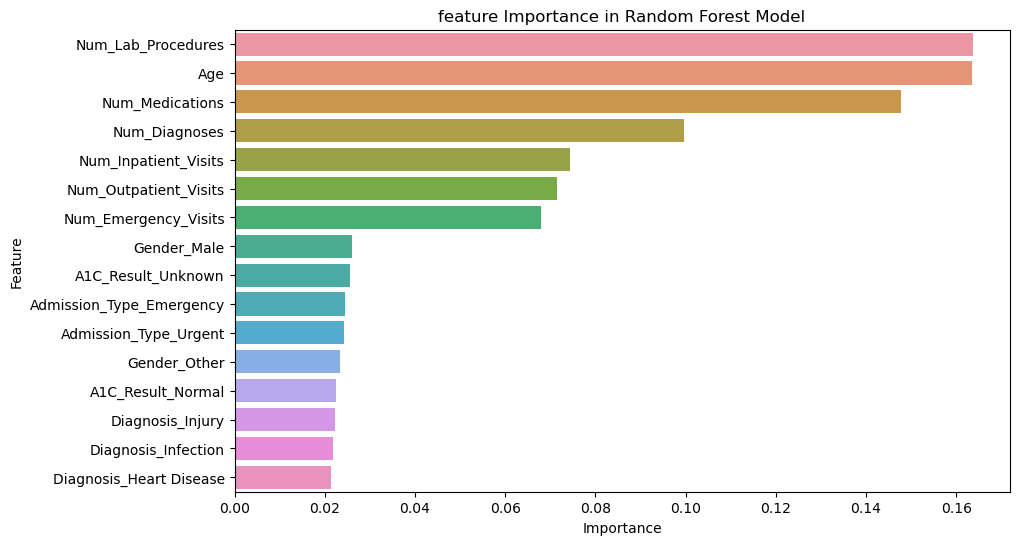

In [18]:
# Extracting and visualizing feature importances
importances = rf_model.feature_importances_

features = pd.DataFrame({
    'Feature' : x_train.columns,
    'Importance' : importances
})

features_sorted = features.sort_values(by='Importance', ascending=False)

print(features_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_sorted)
plt.title('feature Importance in Random Forest Model')
plt.show()

In [19]:
y_pred = rf_model.predict(x_test)

#Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.48484848484848486
Classification Report:               precision    recall  f1-score   support

           0       0.51      0.48      0.49       155
           1       0.46      0.49      0.48       142

    accuracy                           0.48       297
   macro avg       0.49      0.49      0.48       297
weighted avg       0.49      0.48      0.49       297

ROC-AUC Score: 0.48518855065879146


In [20]:
# As the Random Forest Classification is giving low accuracy we need to do feature scaling for numerical data and run other models
# Feature Scaling using StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
x_train_standard = standard_scaler.fit_transform(x_train)
x_test_standard = standard_scaler.transform(x_test)

# Feature Scaling using MinMaxScaler
minmax_scaler = MinMaxScaler()
x_train_minmax = minmax_scaler.fit_transform(x_train)
x_test_minmax = minmax_scaler.transform(x_test)

In [21]:
# Building a logistic regression model

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train_minmax, y_train)

y_pred = logreg.predict(x_test_minmax)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.48148148148148145
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       155
           1       0.46      0.48      0.47       142

    accuracy                           0.48       297
   macro avg       0.48      0.48      0.48       297
weighted avg       0.48      0.48      0.48       297

ROC-AUC Score: 0.4813721035892776


In [22]:
# Building a logistic regression model

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train_standard, y_train)

y_pred = logreg.predict(x_test_standard)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.48148148148148145
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       155
           1       0.46      0.48      0.47       142

    accuracy                           0.48       297
   macro avg       0.48      0.48      0.48       297
weighted avg       0.48      0.48      0.48       297

ROC-AUC Score: 0.4813721035892776


In [23]:
# As both RF and Logistic regression model is giving below 50% accuracy we should try another model.
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_clf.fit(x_train_minmax, y_train)

y_pred_xgb = xgb_clf.predict(x_test_minmax)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

Accuracy: 0.48148148148148145
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50       155
           1       0.46      0.46      0.46       142

    accuracy                           0.48       297
   macro avg       0.48      0.48      0.48       297
weighted avg       0.48      0.48      0.48       297

ROC-AUC Score: 0.4804861426624262


In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'), 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train_minmax, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
Best Score: 0.5353535353535354


In [25]:
# Adjust train-test split
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(
    x, y, test_size=0.2, random_state=42)  # 80% training and 20% testing

# Apply the same scaling to the adjusted training and test sets
X_train_adj_scaled = minmax_scaler.fit_transform(X_train_adj)
X_test_adj_scaled = minmax_scaler.transform(X_test_adj)

# Initialize and train the XGBoost model with best parameters
xgb_clf_adj = xgb.XGBClassifier(learning_rate=0.01, max_depth=7, n_estimators=50, eval_metric='logloss')
xgb_clf_adj.fit(X_train_adj_scaled, y_train_adj)

# Predict on the adjusted test set
y_pred_adj = xgb_clf_adj.predict(X_test_adj_scaled)

# Evaluate the model
print("Adjusted Accuracy:", accuracy_score(y_test_adj, y_pred_adj))
print("Adjusted Classification Report:\n", classification_report(y_test_adj, y_pred_adj))
print("Adjusted ROC-AUC Score:", roc_auc_score(y_test_adj, y_pred_adj))

Adjusted Accuracy: 0.42424242424242425
Adjusted Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.49      0.46        99
           1       0.41      0.35      0.38        99

    accuracy                           0.42       198
   macro avg       0.42      0.42      0.42       198
weighted avg       0.42      0.42      0.42       198

Adjusted ROC-AUC Score: 0.42424242424242425


In [26]:
# We have found out increasing the training data isn't improving the results
# We can filter out important features and see if the model has better accuracy
important_features = [
    'Num_Lab_Procedures', 'Age', 'Num_Medications', 'Num_Diagnoses', 
    'Num_Inpatient_Visits', 'Num_Outpatient_Visits', 'Num_Emergency_Visits'
]
# create training and testing set with selected features
x_train_selected = x_train[important_features]
x_test_selected = x_test[important_features]

# Scaling seleced features
x_train_selected_scaled = minmax_scaler.fit_transform(x_train_selected)
x_test_selected_scaled = minmax_scaler.transform(x_test_selected)

In [27]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))
    print("-----------------------------------\n")

In [28]:
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(x_train_selected_scaled, y_train)

y_pred_rf = rf_selected.predict(x_test_selected_scaled)
evaluate_model(y_test, y_pred_rf, 'Random Forest')

Model: Random Forest
Accuracy: 0.47474747474747475
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50       155
           1       0.45      0.44      0.44       142

    accuracy                           0.47       297
   macro avg       0.47      0.47      0.47       297
weighted avg       0.47      0.47      0.47       297

ROC-AUC Score: 0.4731485688323489
-----------------------------------



In [29]:
logreg_selected = LogisticRegression()
logreg_selected.fit(x_train_selected_scaled, y_train)

y_pred_logreg = logreg_selected.predict(x_test_selected_scaled)
evaluate_model(y_test, y_pred_logreg, 'Logistic Regression')

Model: Logistic Regression
Accuracy: 0.5016835016835017
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       155
           1       0.48      0.49      0.48       142

    accuracy                           0.50       297
   macro avg       0.50      0.50      0.50       297
weighted avg       0.50      0.50      0.50       297

ROC-AUC Score: 0.5010222626079055
-----------------------------------



In [30]:
xgb_selected = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_selected.fit(x_train_selected_scaled, y_train)

y_pred_xgb = xgb_selected.predict(x_test_selected_scaled)
evaluate_model(y_test, y_pred_xgb, 'XGBoost')

Model: XGBoost
Accuracy: 0.4511784511784512
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49       155
           1       0.42      0.40      0.41       142

    accuracy                           0.45       297
   macro avg       0.45      0.45      0.45       297
weighted avg       0.45      0.45      0.45       297

ROC-AUC Score: 0.4490913221263063
-----------------------------------



In [31]:
# Define a range of hyperparameters for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    # 'solver': ['liblinear']  # Uncomment this if you want to include 'l1' penalty
}

# Initialize the Grid Search model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train_selected_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Score: 0.5094150766343446


In [32]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', C=1, probability=True)
svm_clf.fit(x_train_selected_scaled, y_train)

y_pred_svm = svm_clf.predict(x_test_selected_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM ROC-AUC Score:", roc_auc_score(y_test, y_pred_svm))


SVM Accuracy: 0.5151515151515151
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.63      0.57       155
           1       0.49      0.39      0.44       142

    accuracy                           0.52       297
   macro avg       0.51      0.51      0.51       297
weighted avg       0.51      0.52      0.51       297

SVM ROC-AUC Score: 0.5100863243980008


In [33]:
# Hypertunig SVC model with the current parameters is not working and it just keeps running We need to find another way.
pip freeze > requirement.txt

SyntaxError: invalid syntax (178162324.py, line 2)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel
}

# Initialize the Grid Search model
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train_selected_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(x_test_selected_scaled)

# Performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred_best_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_best_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_best_svm))
